In [26]:
using Pkg
Pkg.activate(".")

using Revise
using JLD2, Tullio, TensorCast, OffsetArrays, TensorTrains, MatrixProductBP
using Plots
includet("bp_fourier.jl")

  Activating project at `c:\Users\fefif\Desktop\PhD\Progetti\MatrixProductBP.jl`


In [27]:
D = load("messages.jld2")
μ = D["msg"][5:8]

4-element Vector{TensorTrain{Float64, 4}}:
 TensorTrain{Float64, 4}([[-1.3640365750732782e-17 1.3640365750732782e-17;;; -0.5735473086874396 -0.4368102784605111;;;; 0.0 0.0;;; -0.5735473086874396 0.4368102784605111], [-0.22814301716783109 -0.1737523885971358; -0.22814301716783097 -0.1737523885971357;;; -0.22814301716783097 -0.17375238859713577; 0.228143017167831 0.17375238859713577;;;; -0.22814301716783097 0.17375238859713577; -0.22814301716783095 0.17375238859713574;;; -0.2281430171678309 0.17375238859713577; 0.22814301716783097 -0.17375238859713577], [-0.22814301716783095 -0.1737523885971358; -0.22814301716783097 -0.17375238859713585;;; -0.22814301716783095 -0.1737523885971358; 0.228143017167831 0.17375238859713577;;;; -0.22814301716783095 0.17375238859713585; -0.22814301716783092 0.17375238859713585;;; -0.22814301716783095 0.17375238859713585; 0.22814301716783095 -0.17375238859713588], [-0.22814301716783095 -0.17375238859713588; -0.2281430171678309 -0.17375238859713585;;; -0.22814301

In [28]:
function aggregate(AA)
    function tensorprod(A₁, A₂)
        B = map(zip(A₁, A₂)) do (A₁ᵗ, A₂ᵗ)
            b = zeros(size(A₁ᵗ,1), size(A₂ᵗ,1), size(A₁ᵗ,2), size(A₂ᵗ,2), size(A₁ᵗ,3)+size(A₂ᵗ,3)-1, size(A₁ᵗ,4), size(A₂ᵗ,4))
            @tullio b[m1,m2,n1,n2,y,o1,o2] = A₁ᵗ[m1,n1,x₁,o1] * A₂ᵗ[m2,n2,x₂,o2] * (x₁+x₂-1==y)
            @cast _[(m1,m2),(n1,n2),y,(o1,o2)] := b[m1,m2,n1,n2,y,o1,o2]
        end
    end

    B = [copy(Aᵗ) for Aᵗ in AA[1]]
    for i in 2:length(AA)
        B = tensorprod(B,[A for A in AA[i]])
    end

    return TensorTrain(B)
end
;

In [29]:
N = 4       # number of "neighbours"
J = fill(1.0, N)
d = 4       # bond dimension for truncations
T = 5       # length of tensor train
q = (2, )   # number of values for the variables
K = 50      # number of frequencies
P = 2.0     # period for basis functions
σ = 1/50    # std for the approximation of the pdf for spins

svd_trunc = TruncBond(d)
;

In [30]:
Py = aggregate(μ)

TensorTrain{Float64, 4}([[3.4618166496236062e-68 -3.4618166496236062e-68 … -3.4618166496236062e-68 3.4618166496236062e-68;;; 5.822470332085702e-51 -3.2582629045287035e-51 … 1.870151950585294e-51 -4.434359378142293e-51;;; 3.6723306213773805e-34 -4.377525406994824e-35 … 3.3338977675151393e-35 2.130045986475388e-34;;; 1.0294227114784016e-17 3.306460629329657e-18 … -3.341333238733484e-18 -4.547414624548096e-18;;; 0.10821238896003312 0.08241392303397334 … 0.047802189967951374 0.036405868521479055;;;; 0.0 0.0 … 0.0 0.0;;; 1.4556175830214256e-51 -1.1085898445355732e-51 … -1.4556175830214256e-51 1.1085898445355732e-51;;; 1.8361653106886905e-34 -1.398412769989208e-34 … 1.398412769989208e-34 -1.065022993237694e-34;;; 7.720670336088013e-18 -5.880017408025662e-18 … -4.478186894870508e-18 3.4105609684110723e-18;;; 0.10821238896003312 -0.08241392303397334 … 0.047802189967951374 -0.036405868521479055;;;; 0.0 0.0 … 0.0 0.0;;; 1.4556175830214256e-51 -1.4556175830214256e-51 … -1.1085898445355732e-51 1.1

In [31]:
scale = N+2
μ_fourier = [FourierTensorTrain_spin(μ[k], K, scale, P, σ) for k in eachindex(μ)]
Py_fourier = convolution(μ_fourier, J, P; K, scale, svd_trunc)
;

In [32]:
time = 1

y_marg = marginalize(Py) |> marginals
marg = y_marg[time]

y_marg_fourier = marginals(marginalize(Py_fourier), 2.0)
marg_fourier = y_marg_fourier[time]

display(marg)
display(marg_fourier);

5-element Vector{Float64}:
 1.9994341006683315e-68
 6.725743683373628e-51
 8.484080835544882e-34
 4.7564919385459936e-17
 1.0

#249 (generic function with 1 method)

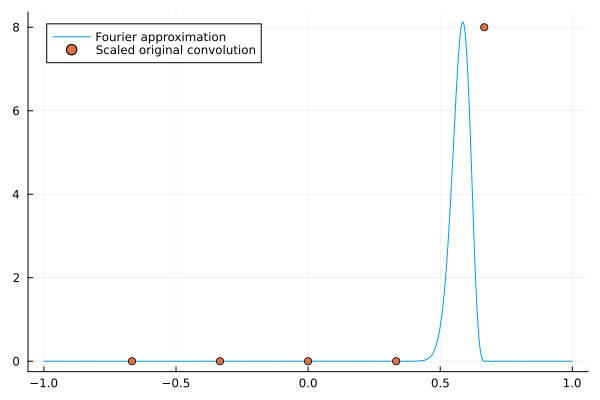

In [33]:
xscatter = range(-N/scale,N/scale,length=N+1)
yscatter = marg
xplot = collect(-1:0.001:1)
yplot = marg_fourier.(xplot)
# scatter(xscatter, yscatter, label="Original convolution")
plot(xplot, yplot, label="Fourier approximation")
# ylims!(-1.5,8.5)

height = 8
scatter!(xscatter, yscatter.*height, label="Scaled original convolution")
# scatter!([-N/scale,N/scale], [0,0])